### Convolutional Neural Network

Perform multiclass classification using a CNN to identify Pokemon. Dataset consists of 1,191 images of Pokemon. They belong to 1 of 5 different classes. 

In [0]:
import os
import numpy as np
import random
import pickle
import cv2
from imutils import paths
import imutils
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
from imutils import paths
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, BatchNormalization, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Implement a smaller version of VGGNet

In [0]:
class SmallerVGGNet:
  @staticmethod

  def build(width,height,depth,classes):
    # initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
    
    model = Sequential()
    inputShape = (height, width, depth) #image dimensions
    chanDim = -1

    # if we are using "channels first", update the input shape
		# and channels dimension
    if K.image_data_format() == 'channels_first':
      inputShape =(depth,height,width)
      chanDim = 1

    ##Add layers 
    #Block 1 : CONV->RELU->BATCH_NORM->MAXPOOL->DROPOUT
    model.add(Conv2D(32, (3,3), padding='same', input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3,3)))  #Reduce from 96 x 96 image to 32 x 32
    model.add(Dropout(0.25))

    #Block 2: (CONV->RELU->BATCH_NORM)*2 ->MAXPOOL->DROPOUT
    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(64,(3,3),padding='same'))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    #Block 3: (CONV->RELU->BATCH_NORM)*2 ->MAXPOOL->DROPOUT
    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(128,(3,3),padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    #Block 4: FC->RELU->BATCH_NORM->DROPOUT
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    #Softmax Classifier
    model.add(Dense(classes))
    model.add(Activation('softmax'))

    return model


Initialize important variables required in training

In [0]:
DATA_DIR = '/content/gdrive/My Drive/Colab Notebooks/data/pokemon'
imagePaths = sorted(list(paths.list_images(DATA_DIR)))
random.shuffle(imagePaths)

# initialize the number of epochs to train for, initial learning rate,
# batch size, and image dimensions
EPOCHS = 100
INIT_LR = 1e-3
BATCH_SIZE = 32
IMAGE_DIMS = (96,96,3)

#initialize the data and labels
data, labels = [],[]

Read the data and labels

In [0]:
for imagePath in imagePaths:
  #load the image, preprocess it and store in data list
  image = cv2.imread(imagePath)
  image = cv2.resize(image,(IMAGE_DIMS[1],IMAGE_DIMS[0]))
  image = img_to_array(image)
  data.append(image)

  #Extract class label from image path
  label = imagePath.split(os.path.sep)[-2]
  labels.append(label)

Normalize the data array, binarize labels and split data in train and test sets

In [0]:
#normalize raw pixel values to [0,1]
data = np.array(data,dtype='float')/255.0
labels = np.array(labels)
print ("Data Matrix (MB) : ",data.nbytes/(1024*1000.0))

#binarize the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

#partition the data into training and testing splits using 80%-20%
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, random_state=42)


Data Matrix (MB) :  252.072


Use data augmentation during training process to give our network more images to learn from

In [0]:
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1, 
                         height_shift_range=0.1, shear_range=0.2,
                         zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

Compile the model and train it

In [0]:
#initialize the model
model = SmallerVGGNet.build(width=IMAGE_DIMS[1], height=IMAGE_DIMS[0], depth=IMAGE_DIMS[2], classes=len(lb.classes_))

#compile it
opt = Adam(lr=INIT_LR, decay=INIT_LR/EPOCHS)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=["accuracy"])

#train the network
H = model.fit_generator(aug.flow(trainX,trainY,batch_size=BATCH_SIZE),
    validation_data=(testX,testY), 
    steps_per_epoch = len(trainX) // BATCH_SIZE, 
    epochs=EPOCHS, verbose=1)












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
29/29 [==============================] - 8s 271ms/step - loss: 1.3082 - acc: 0.6621 - val_loss: 1.3187 - val_acc: 0.7607
Epoch 2/100
29/29 [==============================] - 3s 103ms/step - loss: 0.8733 - acc: 0.7581 - val_loss: 3.1024 - val_acc: 0.5983
Epoch 3/100
29/29 [==============================] - 3s 109ms/step - loss: 0.7114 - acc: 0.7730 - val_loss: 1.0490 - val_acc: 0.7350
Epoch 4/100
29/29 [==============================] - 3s 102ms/step - loss: 0.5859 - acc: 0.8118 - val_loss: 0.8024 - val_acc: 0.7949
Epoch 5/100
29/29 [==============================] - 3s 102ms/step - loss: 0.5727 - acc: 0.8283 - val_loss: 1.2688 - val_acc: 0.7564
Epoch 6/100
29/29 [==============================] - 3s 103ms/step - loss: 0.6355 - acc: 0.8075 - val_loss: 0.48

Save the model and binarizer

In [0]:
model.save('./gdrive/My Drive/Colab Notebooks/models/pokemon_smallVGG.h5')
f = open('./gdrive/My Drive/Colab Notebooks/models/pokemon_LabelBinarizer','wb')
f.write(pickle.dumps(lb))
f.close()

Plot training & loss accuracy

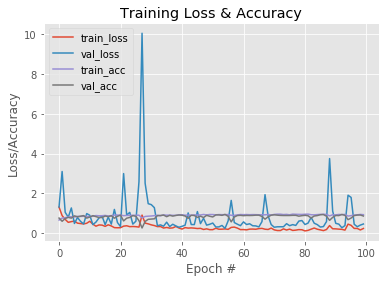

In [0]:
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, EPOCHS), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, EPOCHS), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), H.history["val_acc"], label="val_acc")

plt.title('Training Loss & Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend(loc='upper left')
plt.show()

Test the trained model

In [0]:
model = load_model('./gdrive/My Drive/Colab Notebooks/models/pokemon_smallVGG.h5')
lb = pickle.loads(open('./gdrive/My Drive/Colab Notebooks/models/pokemon_LabelBinarizer','wb', "rb").read())

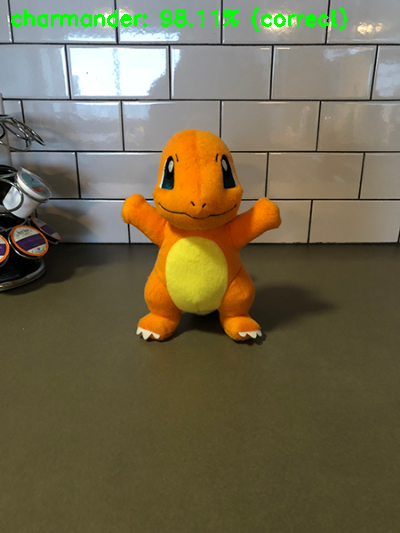

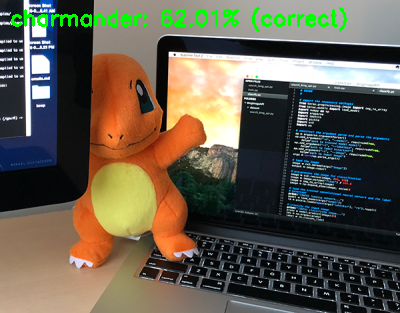

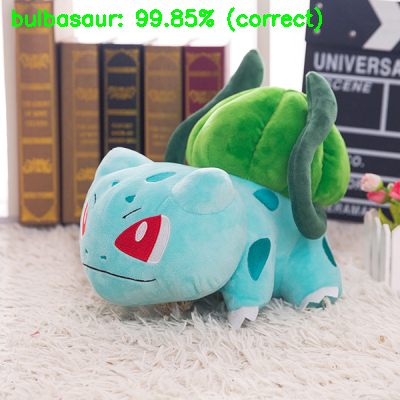

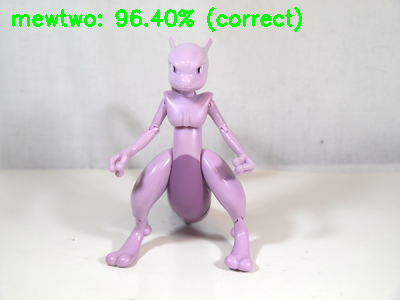

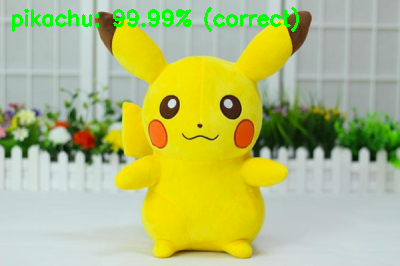

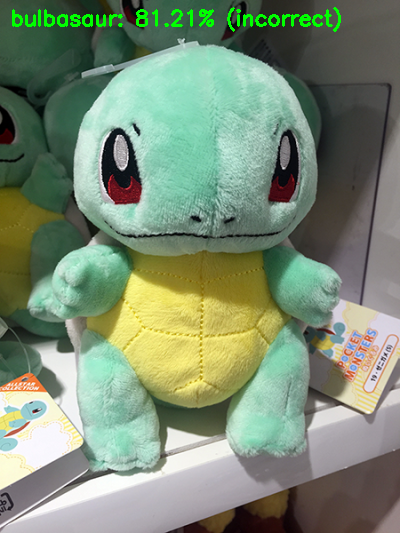

In [0]:
TEST_DIR ='/content/gdrive/My Drive/Colab Notebooks/data/pokemon_examples'
imagePaths = list(paths.list_images(TEST_DIR))

for imagePath in imagePaths:
  image = cv2.imread(imagePath)
  output = image.copy()

  #preprocess image
  image = cv2.resize(image,(96,96))
  image = image.astype("float")/255.0
  image = img_to_array(image)
  image = np.expand_dims(image, axis=0)

  proba = model.predict(image)[0]
  idx = np.argmax(proba)
  label = lb.classes_[idx]

  # we'll mark our prediction as "correct" of the input image filename
  # contains the predicted label text (obviously this makes the
  # assumption that you have named your testing image files this way)
  filename = imagePath[imagePath.rfind(os.path.sep) + 1:]
  correct = "correct" if filename.rfind(label) != -1 else "incorrect"

  # build the label and draw the label on the image
  label = "{}: {:.2f}% ({})".format(label, proba[idx] * 100, correct)
  output = imutils.resize(output, width=400)
  cv2.putText(output, label, (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (0, 255, 0), 2)
  cv2_imshow(output)

Reference - 
https://www.pyimagesearch.com/2018/04/16/keras-and-convolutional-neural-networks-cnns/
